# tiny rollout
* roll out is checked with comma logic
* used to hand tune a simple controller the linear combination of target, act and roll

In [1]:
#!pip install onnx
#!pip install onnx2torch

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.pylab import plt
import onnx
import time
from onnx2torch import convert

print("torch version ",torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print(device)

C:\Users\yufen\anaconda3\envs\torch23\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


torch version  2.3.0
cuda


In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
#  f.write('Hello Google Drive!')
#!cat /content/gdrive/My\ Drive/foo.txt

In [4]:
ACC_G = 9.81
CONTROL_START_IDX = 100
CONTEXT_LENGTH = 20
VOCAB_SIZE = 1024
LATACCEL_RANGE = [-5, 5]
STEER_RANGE = [-2, 2]
MAX_ACC_DELTA = 0.5
DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 5.0

temperature = 1.0
DATA_LENGTH = 598

In [5]:
# Path to ONNX model
#onnx_model_path = "/content/gdrive/My Drive/colab_data/tinyphysics.onnx"
onnx_model_path = "models/tinyphysics.onnx"
onnx_model = onnx.load(onnx_model_path)

torch_model = convert(onnx_model).to(device)
torch_model.eval()



GraphModule(
  (initializers): Module()
  (Identity_0): OnnxCopyIdentity()
  (Identity_1): OnnxCopyIdentity()
  (Identity_2): OnnxCopyIdentity()
  (Shape): OnnxShape()
  (Constant): OnnxConstant()
  (Gather): OnnxGather()
  (Constant_1): OnnxConstant()
  (Cast): OnnxCast()
  (Constant_2): OnnxConstant()
  (Range): OnnxRange()
  (Constant_3): OnnxConstant()
  (Unsqueeze): OnnxUnsqueezeStaticAxes()
  (Constant_4): OnnxConstant()
  (Constant_13): OnnxConstant()
  (Unsqueeze_1): OnnxUnsqueezeStaticAxes()
  (Concat): OnnxConcat()
  (Reshape): OnnxReshape()
  (wt_embedding/MatMul): OnnxMatMul()
  (wt_embedding/Add): OnnxBinaryMathOperation()
  (wt2_embedding/Gather): OnnxGather()
  (wp_embedding/Gather): OnnxGather()
  (Concat_1): OnnxConcat()
  (Add): OnnxBinaryMathOperation()
  (h/0/attn/Shape): OnnxShape()
  (h/0/attn/Constant): OnnxConstant()
  (h/0/attn/Gather): OnnxGather()
  (h/0/attn/Shape_1): OnnxShape()
  (h/0/attn/Constant_1): OnnxConstant()
  (h/0/attn/Gather_1): OnnxGather()
  (

In [6]:
input_shape = onnx_model.graph.input[0].type.tensor_type.shape.dim
input_shape = [dim.dim_value for dim in input_shape]
print("Input shape 1:", input_shape)

Input shape 1: [0, 20, 4]


In [7]:
input_shape = onnx_model.graph.input[1].type.tensor_type.shape.dim
input_shape = [dim.dim_value for dim in input_shape]
print("Input shape 2:", input_shape)

Input shape 2: [0, 20]


In [8]:
#data=np.load("/content/gdrive/My Drive/colab_data/data32.npy")
data=np.load("data32.npy")
print(data.shape)

(19945, 598, 6)


19945 path, 55 got discarded,
598 time step, each 0.1 second, last 2 time step got discard since it is missing for a lot files
6 date field,  data are t, vEgo, aEgo, roll, targetLateralAcceleration, steerCommand
roll is in angle, need to convert to accelation with sin()*9.81
also need to tokenize the steercommand


In [9]:
data[:,:,3]=np.sin(data[:,:,3]) * ACC_G

In [10]:
data_tensor=torch.from_numpy(data).float().to(device)

In [11]:
# add a dimension to split the first index by batch number and path.

# for training will have 1024 path per batch
# will only train on the first 16 batch scenario, the reslt will be validation
# issues with batch 7 and batch 11, will skip

# the tensor calculated in this cell shall not be updated from now on
# everytime a slice of the tensor are used elsewhere, a clone shall be made
batch_size = 5000
batch_count = 1

data_t = data_tensor[:batch_size*batch_count]
data_v = data_tensor[batch_size*batch_count:]
data_t = data_t.view(batch_count,batch_size,DATA_LENGTH,6)

In [12]:
data_t.shape

torch.Size([1, 5000, 598, 6])

In [13]:
# all the following history list have tensor inside, the first dimension should be 1024 for batch size
state_history=[]
target_lataccel_history=[]

#follow State = namedtuple('State', ['roll_lataccel', 'v_ego', 'a_ego']) for defination
for step_idx in range(DATA_LENGTH):
    target_lataccel_history.append(data_t[...,step_idx,4].clone())
    state=torch.zeros((batch_count,batch_size,3),device=device)
    state[..., 0]=data_t[..., step_idx, 3]
    state[..., 1]=data_t[..., step_idx, 1]
    state[..., 2]=data_t[..., step_idx, 2]
    state_history.append(state)
    del state

In [14]:
x = torch.tensor([0.4, 0.1, 0.35])

def simple_is_good(target, act, roll):
    return x[0] * target + x[1] * (target-act ) - x[2]*roll

In [15]:
%%time

for b in range(batch_count):
    
    if b== 7 or b == 11 :
        continue   
    
    current_lataccel_history=[]
    token_lataccel_history=[]    # this is the tokenized current_lataccel_history, 1 to 1 mapping
    action_history=[]
        
    for step_idx in range(CONTROL_START_IDX):
        action_history.append(data_t[b,:,step_idx,5].clone())
    
    for step_idx in range(CONTROL_START_IDX):
        current_lataccel_history.append(data_t[b,...,step_idx,4].clone()) # use target for actual before control start
        token_lataccel_history.append(torch.round((current_lataccel_history[-1]+5)*1023/10+0.4999).int()) #encoder
        
    for step_idx in range(CONTEXT_LENGTH, DATA_LENGTH):
    
        if step_idx >= CONTROL_START_IDX:
            
            #action=(target_lataccel_history[step_idx][b]-current_lataccel_history[-1])*0.3 # simple controller
            #action=torch.zeros_like(current_lataccel_history[-1]) # zero controller
            action=simple_is_good(target_lataccel_history[step_idx][b],
                                  current_lataccel_history[-1],
                                  state_history[step_idx][b,:,0])
            action_history.append(action)
    
        action = torch.stack(action_history[step_idx + 1 - CONTEXT_LENGTH : step_idx + 1],1)
        state = torch.stack([tensor[b] for tensor in state_history[step_idx + 1 - CONTEXT_LENGTH : step_idx + 1]],1)
        action=action.unsqueeze(-1)
        input1=torch.cat((action, state), dim=-1)
        input2 = torch.stack(token_lataccel_history[step_idx - CONTEXT_LENGTH : step_idx],1)
        o1 =torch_model(input1, input2)
    
        probs = F.softmax(o1 / temperature, dim=-1)

        # original method, won't pass the gradient 
        sample = torch.multinomial(probs[:, -1], num_samples=1).squeeze(1) 
        pred = -5.0 + sample / 102.3 # decoder :)
        
        current_lataccel=current_lataccel_history[-1]
        pred = torch.clip(pred, current_lataccel - MAX_ACC_DELTA, current_lataccel + MAX_ACC_DELTA)

        token_lataccel=((pred + 5) * 1023 / 10 + 0.4999).int()
        token_lataccel=torch.clip(token_lataccel, 0, 1023)        
        
        if step_idx >= CONTROL_START_IDX:
            current_lataccel_history.append(pred)
            token_lataccel_history.append(token_lataccel) 

    y1=torch.stack(current_lataccel_history,dim=1)[:,CONTROL_START_IDX:]
    y2=data_t[b,:,CONTROL_START_IDX:,4]
    
    lat_accel_cost = torch.mean((y1 - y2)**2) * 100
    jerk_cost = torch.mean((torch.diff(y1) / DEL_T)**2) * 100
    total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost

    print(b, x, lat_accel_cost.item(),jerk_cost.item(),total_cost.item())    

0 tensor([0.4000, 0.1000, 0.3500]) 4.48054313659668 29.731603622436523 52.13431930541992
CPU times: total: 1min 5s
Wall time: 1min 51s


In [16]:
#np.savetxt("y1.txt",y1[0].to("cpu").detach().numpy())

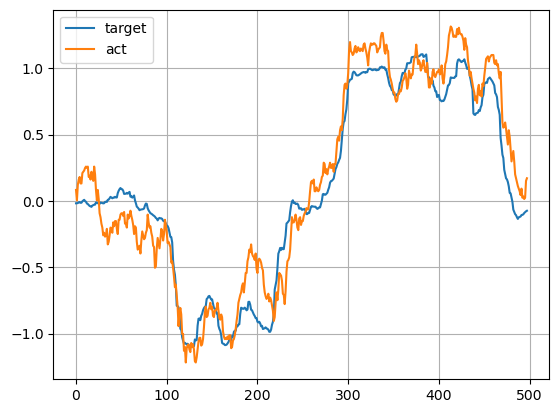

In [20]:
p=0

plt.plot(y2[p].to("cpu").detach().numpy())
plt.plot(y1[p].to("cpu").detach().numpy())
plt.legend(["target","act"])
plt.grid()
